In [116]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, plot_tree
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
import lightgbm as lgb
from catboost import CatBoostClassifier
from xgboost import XGBClassifier, callback, plot_importance
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings("ignore")

In [117]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False, duplicates='drop')+1
    grouped = df_calibracion.groupby('bins').mean()

    plt.plot(grouped.predicciones, grouped.y, label="Modelo", marker="o")
    plt.plot(grouped.predicciones, grouped.predicciones, label="Real", marker="o")
    plt.grid()
    plt.legend()
    plt.xlabel("Prediccion")
    plt.ylabel("Real")

In [118]:
df = pd.read_csv("Data/hr_role.csv")
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,is_satisfied
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,80,0,8,0,1,6,4,0,5,True
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,80,1,10,3,3,10,7,1,7,False
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,80,0,7,3,3,0,0,0,0,False
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,80,0,8,3,3,8,7,3,0,False
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,80,1,6,3,3,2,2,2,2,False


In [119]:
df = pd.get_dummies(df)
df.head()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_No,OverTime_Yes
0,41,1,1102,1,2,2,94,3,2,5993,...,0,0,1,0,0,0,1,1,0,1
1,49,0,279,8,1,3,61,2,2,5130,...,0,1,0,0,0,1,0,1,1,0
2,37,1,1373,2,2,4,92,2,1,2090,...,0,0,0,0,0,0,1,1,0,1
3,33,0,1392,3,4,4,56,3,1,2909,...,0,1,0,0,0,1,0,1,0,1
4,27,0,591,2,1,1,40,3,1,3468,...,0,0,0,0,0,1,0,1,1,0


In [120]:
target = 'Attrition'
y = df[target]

In [121]:
X = df.copy().drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [122]:
arbol2 = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)

# Arbol Max Depth 2

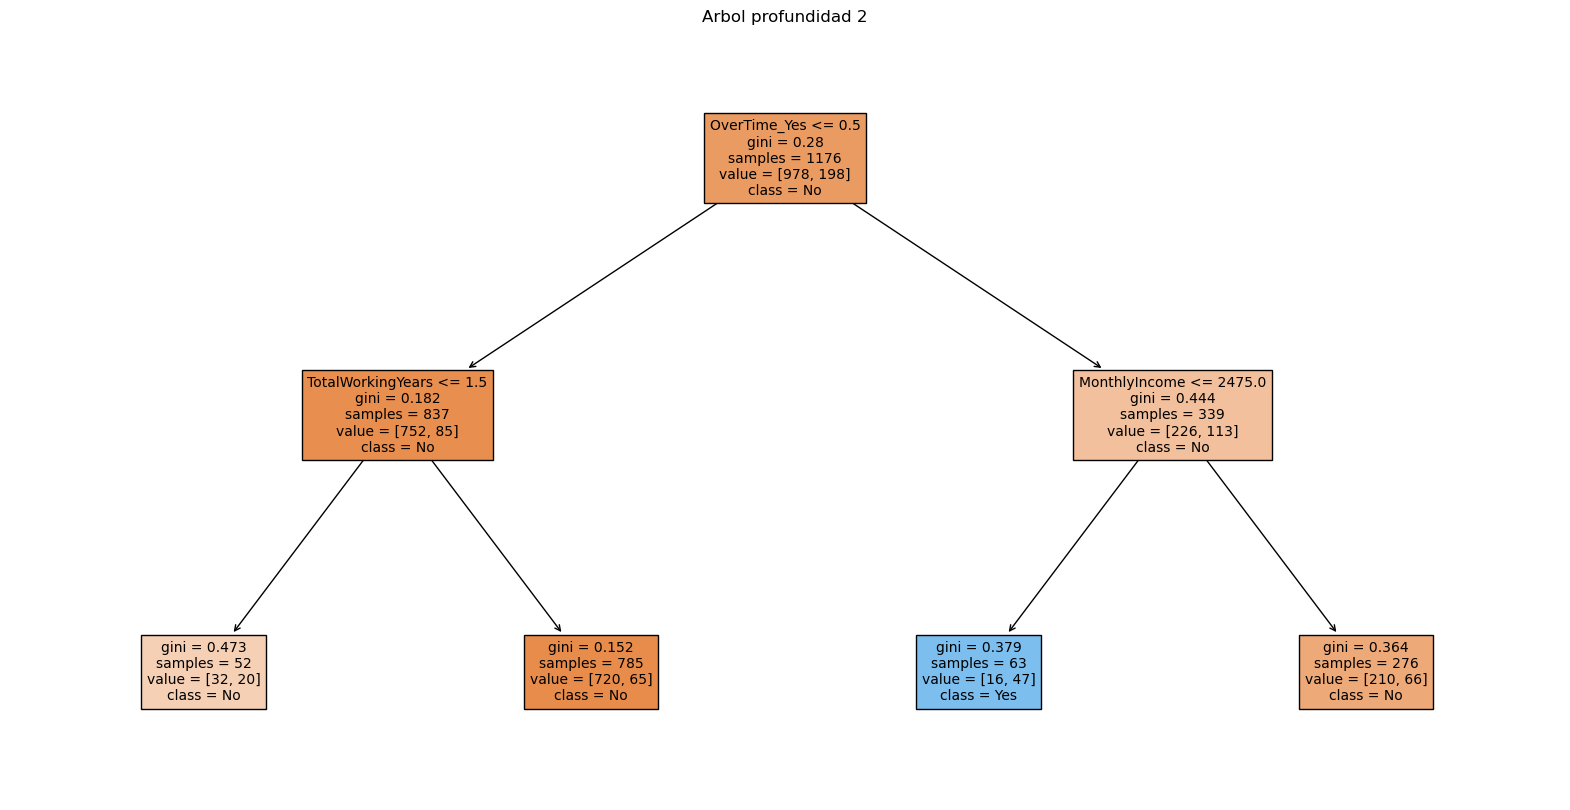

In [123]:
plt.figure(figsize=(20, 10))
plot_tree(arbol2, filled=True, feature_names=X.columns, class_names=["No", "Yes"], fontsize=10)
plt.title("Arbol profundidad 2")
plt.show()

# Mejor Arbol de Decision

In [124]:
pipeline = Pipeline([
    ('tree', DecisionTreeClassifier(random_state=42))
])

params = {
    'tree__max_depth': list(range(1, 10)),
    'tree__max_features': ['log2', 'sqrt', None],
    'tree__min_samples_split': list(range(2, 10)),
    'tree__min_samples_leaf': list(range(1, 10))
}

grid_tree = GridSearchCV(pipeline, params, cv=5, n_jobs=-1, scoring='roc_auc')
grid_tree.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tree',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'tree__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'tree__max_features': ['log2', 'sqrt', None],
                         'tree__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'tree__min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='roc_auc')

In [125]:
best_model = grid_tree.best_estimator_.named_steps['tree']
probabilidades = best_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_score = probabilidades, y_true=y_test)

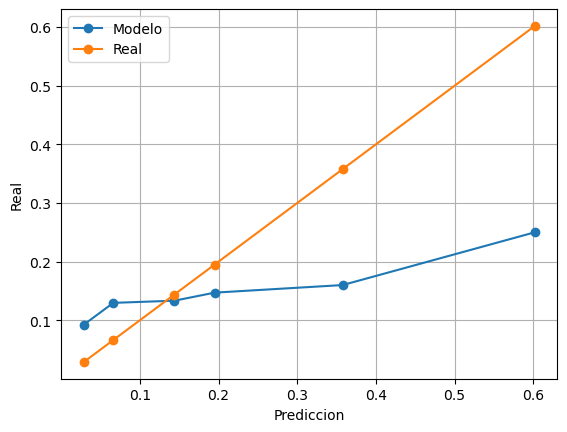

In [126]:
calibracion (probabilidades, y_test, 10)

In [127]:
roc_auc_score(y_test, probabilidades)

0.5947209653092006

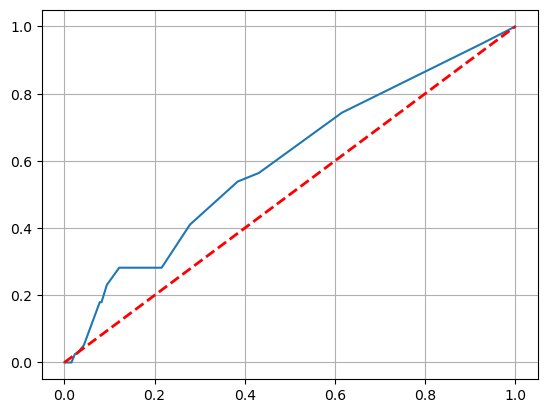

In [128]:
fpr, fnp, scores = roc_curve(y_score=probabilidades, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.grid()
plt.show()

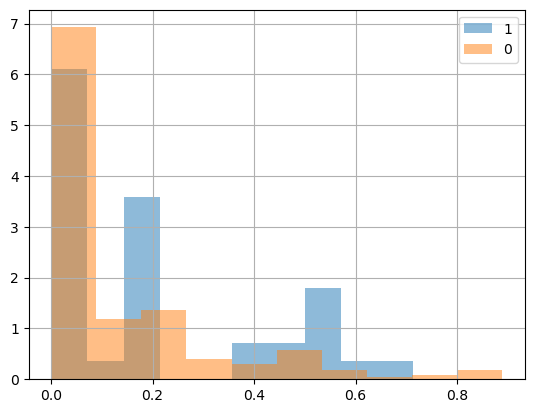

In [129]:
histograma = pd.DataFrame({'target': y_test, 'probabilidades': probabilidades})

proba_1 = histograma[histograma['target'] == 1].probabilidades
proba_0 = histograma[histograma['target']== 0].probabilidades

plt.hist(proba_1, alpha=0.5, density=True, label='1')
plt.hist(proba_0, alpha=0.5, density=True, label='0')
plt.grid()
plt.legend()
plt.show()

# Random Forest

In [130]:
pipeline = Pipeline([
    ('rf', RandomForestClassifier(n_jobs=-1, random_state=42))
])

params = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': list(range(1, 20)),
    'rf__max_features': ['log2', 'sqrt', 10, 12]
}

rf_grid = GridSearchCV(estimator=pipeline, n_jobs=-1, cv=5, scoring='roc_auc', param_grid=params)
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rf',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                           12, 13, 14, 15, 16, 17, 18, 19],
                         'rf__max_features': ['log2', 'sqrt', 10, 12],
                         'rf__n_estimators': [100, 200, 300]},
             scoring='roc_auc')

In [131]:
best_model = rf_grid.best_estimator_.named_steps['rf']
probabilidades = best_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_score = probabilidades, y_true=y_test)

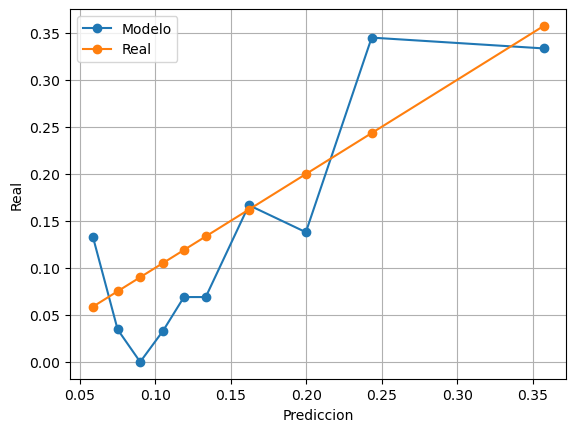

In [132]:
calibracion(probabilidades, y_test, 10)

In [133]:
auc_score = roc_auc_score(y_test, probabilidades)
auc_score

0.7319255907491201

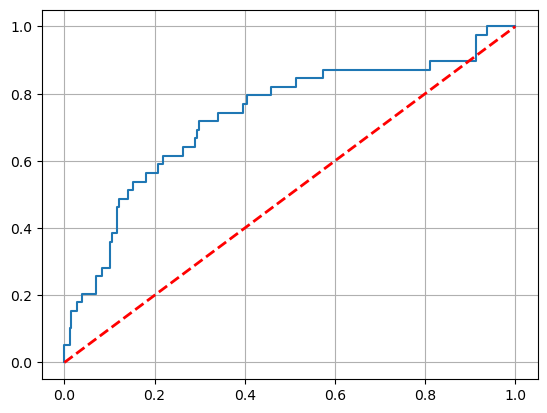

In [134]:
fpr, fnp, scores = roc_curve(y_score=probabilidades, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.grid()
plt.show()

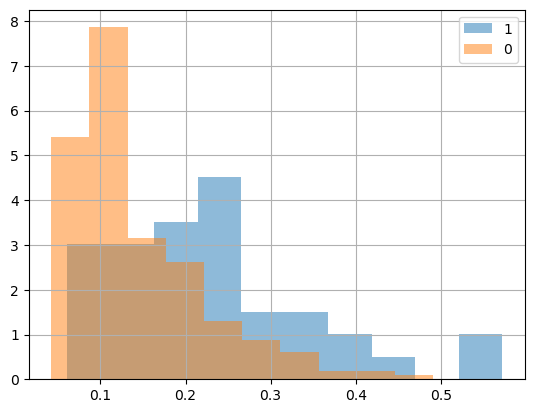

In [135]:
histograma = pd.DataFrame({'target': y_test, 'probabilidades': probabilidades})

proba_1 = histograma[histograma['target'] == 1].probabilidades
proba_0 = histograma[histograma['target']== 0].probabilidades

plt.hist(proba_1, alpha=0.5, density=True, label='1')
plt.hist(proba_0, alpha=0.5, density=True, label='0')
plt.grid()
plt.legend()
plt.show()

## Feature Importance Random Forest

In [136]:
model_interpretability = pd.DataFrame({
    'variables': X_train.keys(),
    'importancia': best_model.feature_importances_
})
model_interpretability

,variables,importancia
0,Age,0.048262
1,DailyRate,0.031662
2,DistanceFromHome,0.026513
3,Education,0.010120
4,EnvironmentSatisfaction,0.018033
5,HourlyRate,0.018770
6,JobInvolvement,0.018837
7,JobLevel,0.046603
8,MonthlyIncome,0.091207
9,MonthlyRate,0.025741


# XGBoost

In [137]:
model = XGBClassifier(
    n_estimators=10000,
    max_depth=5,
    learning_rate = 0.1,
    reg_lambda=0.1,
    subsample = 0.5,
    col_sample_by_tree = 0.8,
    tree_method='hist'
)

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=20, verbose=100)


[12:21:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "col_sample_by_tree" } are not used.

[0]	validation_0-logloss:0.63169	validation_1-logloss:0.64144
[88]	validation_0-logloss:0.08515	validation_1-logloss:0.34663


XGBClassifier(base_score=None, booster=None, callbacks=None,
              col_sample_by_tree=0.8, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

In [138]:
best_model = model
probabilidades = best_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_score= probabilidades, y_true=y_test)
auc_score

0.7722473604826546

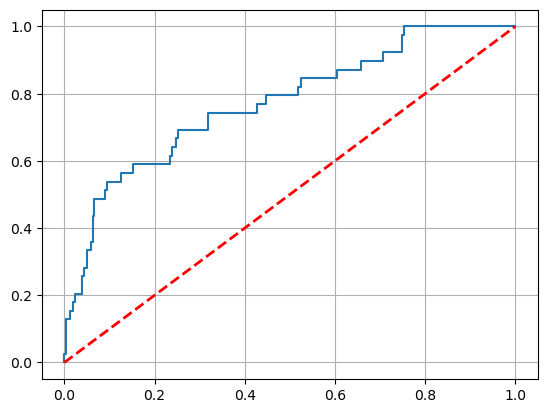

In [139]:
fpr, fnp, scores = roc_curve(y_score=probabilidades, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.grid()
plt.show()

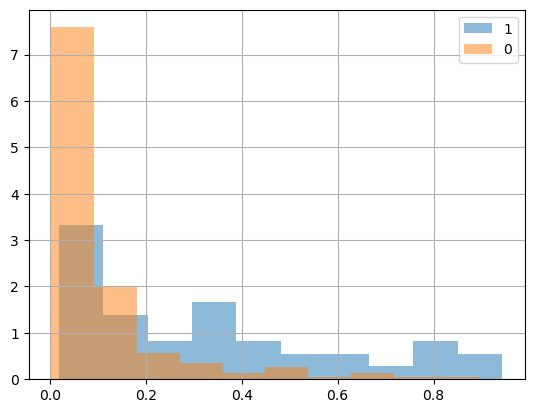

In [140]:
histograma = pd.DataFrame({'target': y_test, 'probabilidades': probabilidades})

proba_1 = histograma[histograma['target'] == 1].probabilidades
proba_0 = histograma[histograma['target']== 0].probabilidades

plt.hist(proba_1, alpha=0.5, density=True, label='1')
plt.hist(proba_0, alpha=0.5, density=True, label='0')
plt.grid()
plt.legend()
plt.show()

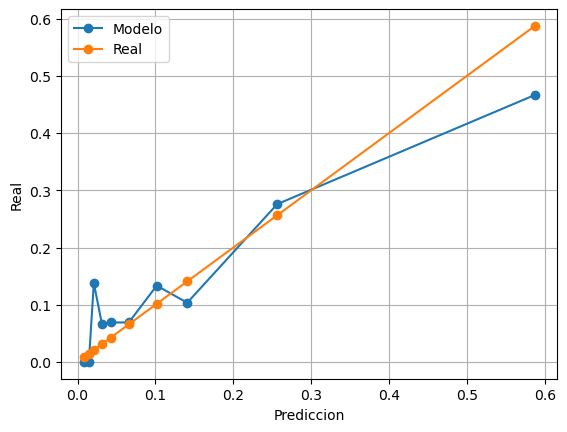

In [141]:
calibracion(probabilidades, y_test, 10)

## Feature Importance XGBoost

In [142]:
model_interpretability = pd.DataFrame({
    'variables': X_train.keys(),
    'importancia': best_model.feature_importances_
})
model_interpretability

,variables,importancia
0,Age,0.021117
1,DailyRate,0.017566
2,DistanceFromHome,0.019300
3,Education,0.016141
4,EnvironmentSatisfaction,0.021640
5,HourlyRate,0.018352
6,JobInvolvement,0.024049
7,JobLevel,0.035634
8,MonthlyIncome,0.023550
9,MonthlyRate,0.018598


## Weight XGBoost

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

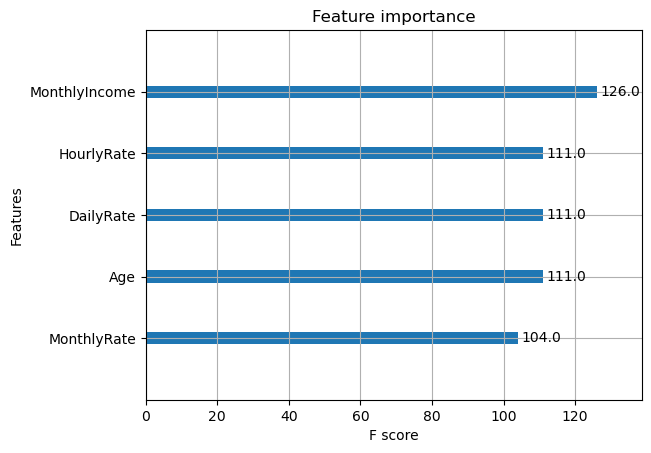

In [143]:
plot_importance(model, max_num_features=5, importance_type='weight')

## Gain XGBoost

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

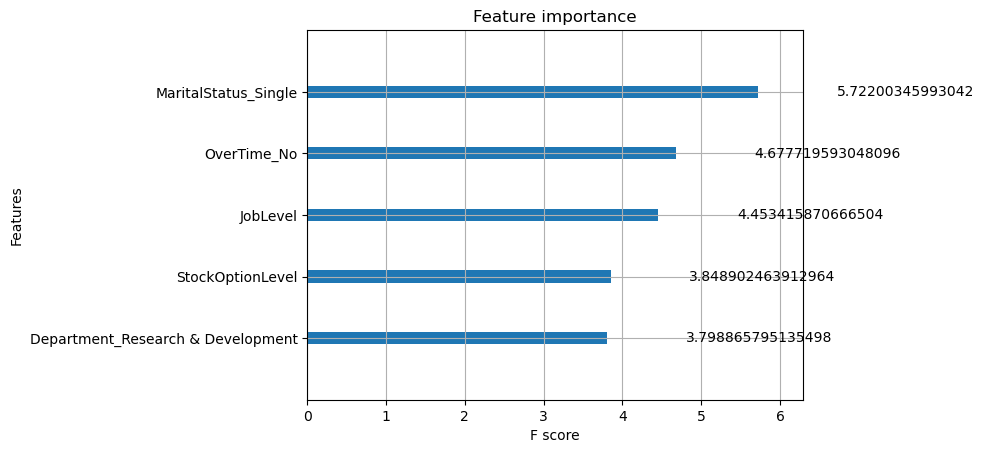

In [144]:
plot_importance(model, max_num_features=5, importance_type='gain')

# LightGBM

In [145]:
model = LGBMClassifier(
    num_iterations=10000,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=6,
    lambda_l2=0.1,
    subsample=0.5,
    feature_fraction=0.8,
    verbosity=-1,
    metric='auc'
)

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], callbacks=[early_stopping(20)])

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[93]	training's auc: 0.996716	valid_1's auc: 0.78904


LGBMClassifier(feature_fraction=0.8, lambda_l2=0.1, max_depth=6, metric='auc',
               num_iterations=10000, num_leaves=10, subsample=0.5,
               verbosity=-1)

In [146]:
best_model = model
probabilidades = best_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_score= probabilidades, y_true=y_test)
auc_score

0.7890397184514831

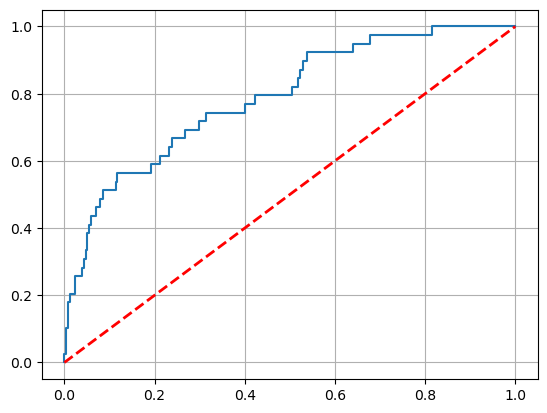

In [147]:
fpr, fnp, scores = roc_curve(y_score=probabilidades, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.grid()
plt.show()

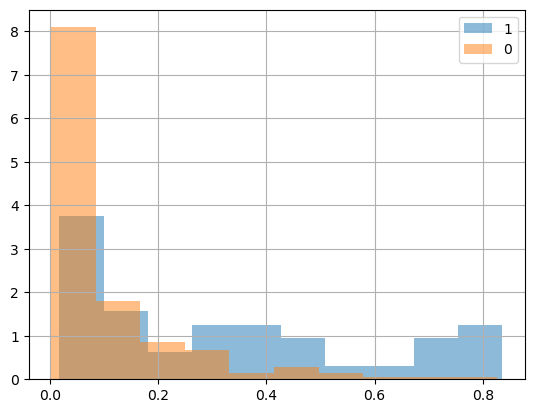

In [148]:
histograma = pd.DataFrame({'target': y_test, 'probabilidades': probabilidades})

proba_1 = histograma[histograma['target'] == 1].probabilidades
proba_0 = histograma[histograma['target']== 0].probabilidades

plt.hist(proba_1, alpha=0.5, density=True, label='1')
plt.hist(proba_0, alpha=0.5, density=True, label='0')
plt.grid()
plt.legend()
plt.show()

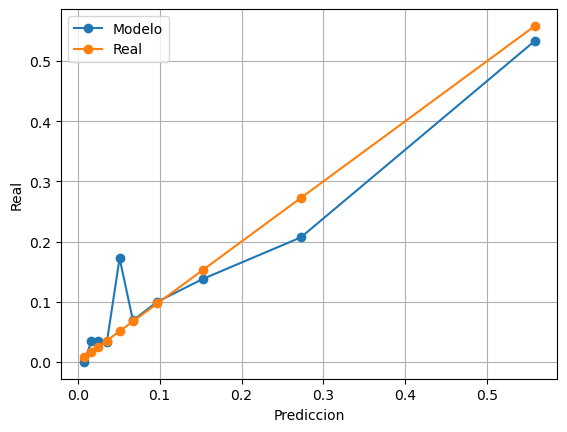

In [149]:
calibracion(probabilidades, y_test, 10)

In [150]:
model_interpretability = pd.DataFrame({
    'variables': X_train.keys(),
    'importancia': best_model.feature_importances_
})
model_interpretability

,variables,importancia
0,Age,43
1,DailyRate,49
2,DistanceFromHome,40
3,Education,4
4,EnvironmentSatisfaction,28
5,HourlyRate,31
6,JobInvolvement,33
7,JobLevel,19
8,MonthlyIncome,79
9,MonthlyRate,41


## Split LightGBM

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

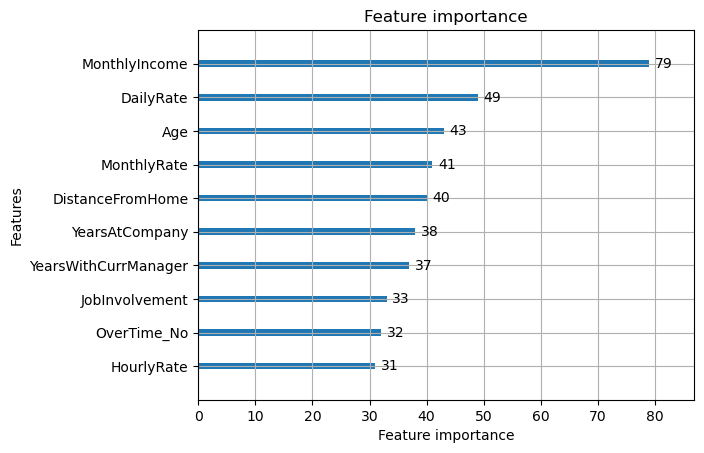

In [151]:
lgb.plot_importance(model, max_num_features=10, importance_type='split')

## Gain LightGBM

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

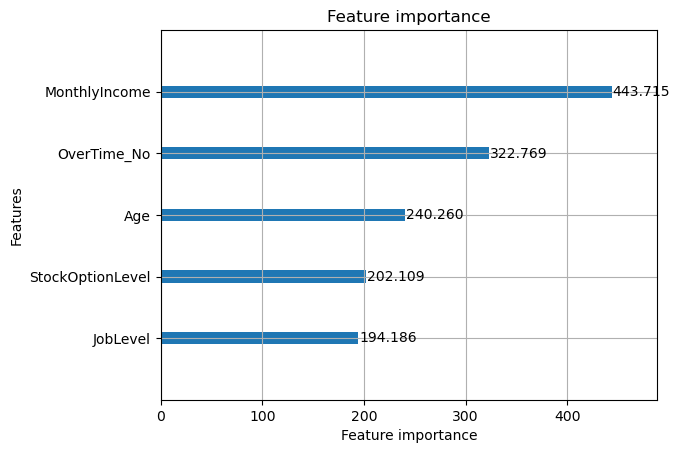

In [152]:
lgb.plot_importance(model, max_num_features=5, importance_type='gain')

# Catboost

In [154]:
cat_cols = [col for col in X_train.columns if X_train[col].nunique() < 50]
for col in cat_cols:
    X_train[col] = X_train[col].astype(str).fillna('missing')
    X_test[col] = X_test[col].astype(str).fillna('missing')

model = CatBoostClassifier(
    iterations=10000,          
    depth=5,                
    learning_rate=0.5,
    subsample=0.25,            
    rsm=0.8,                    
    eval_metric='AUC',           
    l2_leaf_reg=0.1,            
    random_strength=5,         
    verbose=100,
    early_stopping_rounds=20    
)

model.fit(
    X_train, y_train,
    cat_features=cat_cols,
    eval_set=[(X_test, y_test)],
)

0:	test: 0.6429361	best: 0.6429361 (0)	total: 4.39ms	remaining: 43.9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7652086476
bestIteration = 34

Shrink model to first 35 iterations.


In [155]:
best_model = model
probabilidades = best_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_score= probabilidades, y_true=y_test)
auc_score

0.7652086475615887

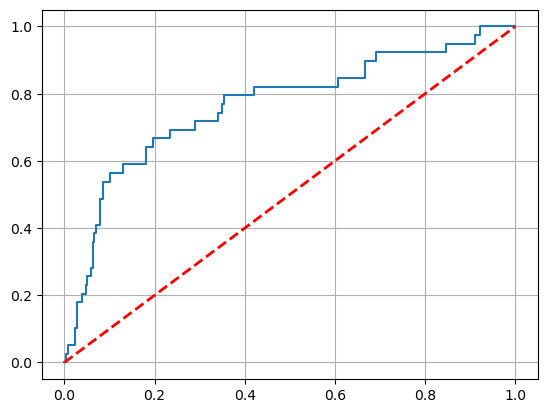

In [156]:
fpr, fnp, scores = roc_curve(y_score=probabilidades, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.grid()
plt.show()

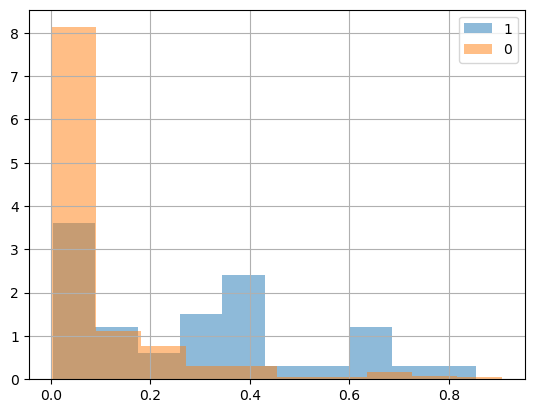

In [157]:
histograma = pd.DataFrame({'target': y_test, 'probabilidades': probabilidades})

proba_1 = histograma[histograma['target'] == 1].probabilidades
proba_0 = histograma[histograma['target']== 0].probabilidades

plt.hist(proba_1, alpha=0.5, density=True, label='1')
plt.hist(proba_0, alpha=0.5, density=True, label='0')
plt.grid()
plt.legend()
plt.show()

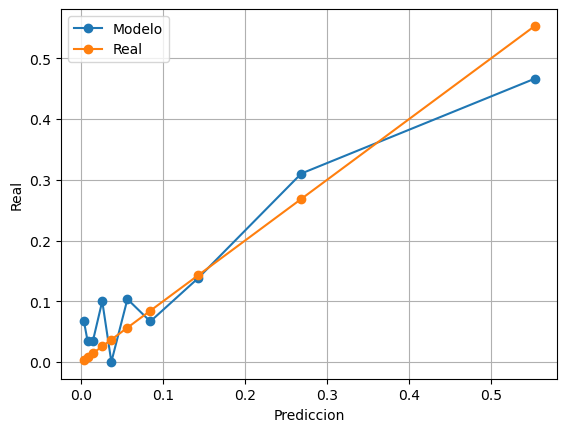

In [158]:
calibracion(probabilidades, y_test, 10)

In [159]:
model_interpretability = pd.DataFrame({
    'variables': X_train.keys(),
    'importancia': best_model.feature_importances_
})
model_interpretability

,variables,importancia
0,Age,5.364750
1,DailyRate,7.809792
2,DistanceFromHome,6.064001
3,Education,1.439146
4,EnvironmentSatisfaction,3.688816
5,HourlyRate,2.377459
6,JobInvolvement,2.922232
7,JobLevel,4.924327
8,MonthlyIncome,6.265483
9,MonthlyRate,5.281431
